### ***This code was used to plot Fig 2 and Fig S5***

#### ***Reading Grid Data***

In [ ]:
import pandas as pd
import glob
import os
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
from matplotlib.colors import  TwoSlopeNorm

In [ ]:
folder_path = r"path_to_folder_stored_grid_scaling"
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

dataframes = []

def extract_info(filename):
    base_name = os.path.basename(filename).replace('.csv', '')
    parts = base_name.split('_')
    
    method = parts[1]
    
    last_part = parts[-1]
    model_scenario = last_part.rsplit('-', 1)
    model = model_scenario[0]
    scenario = model_scenario[1]
    
    return model, scenario, method

for file in csv_files:
    df = pd.read_csv(file)
    filename = os.path.basename(file)
    model, scenario, method = extract_info(filename)
    df['model'] = model
    df['scenario'] = scenario
    df['method'] = method
    dataframes.append(df)
for df in dataframes:
    if 'lat_lon' in df.columns:
        df[['lat', 'lon']] = df['lat_lon'].str.split(',', expand=True)
        df.drop(columns='lat_lon', inplace=True)
    if 'intercept' in df.columns:
        df.drop(columns='intercept', inplace=True)
    if 'Unnamed: 0' in df.columns:
        df.drop(columns='Unnamed: 0', inplace=True)
    if 'slope' in df.columns:
        df.drop(columns='slope', inplace=True)

grid = pd.concat(dataframes, ignore_index = True)
grid["model"].replace("gdfl-esm4", "gfdl-esm4", inplace = True)
grid["model"].replace("mpi-esm1-2", "mpi-esm1-2-lr", inplace = True)

In [16]:
columns_to_convert = ['lat', 'lon']
# Convert the specified columns to float
grid[columns_to_convert] = grid[columns_to_convert].apply(pd.to_numeric)

#### ***Reading Region Data***

In [17]:
folder_path = r"path_to_folder_stored_region_scaling"
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

dataframes = []

def extract_info(filename):
    base_name = os.path.basename(filename).replace('.csv', '')
    parts = base_name.split('_')
    
    method = parts[1]
    
    last_part = parts[-1]
    model_scenario = last_part.rsplit('-', 1)
    model = model_scenario[0]
    scenario = model_scenario[1]
    
    return model, scenario, method

for file in csv_files:
    df = pd.read_csv(file)
    filename = os.path.basename(file)
    model, scenario, method = extract_info(filename)
    df['model'] = model
    df['scenario'] = scenario
    df['method'] = method
    dataframes.append(df)
for df in dataframes:
    if 'lat_lon' in df.columns:
        df[['lat', 'lon']] = df['lat_lon'].str.split(',', expand=True)
        df.drop(columns='lat_lon', inplace=True)
    if 'intercept' in df.columns:
        df.drop(columns='intercept', inplace=True)
    if 'Unnamed: 0' in df.columns:
        df.drop(columns='Unnamed: 0', inplace=True)
    if 'slope' in df.columns:
        df.drop(columns='slope', inplace=True)

reg = pd.concat(dataframes, ignore_index=True)
pix = pd.read_csv("D:\Min\Review GCM\Region and Location\Grouping_Region_SREX.csv")
reg = reg.merge(pix[['lat', 'lon', 'code']], on='code', how='left')

##### ***Spread***

In [18]:
def percentile_90_10(series):
    p90 = np.percentile(series, 90)
    p10 = np.percentile(series, 10)
    return p90 - p10

grid_avg = grid.groupby(['lat', 'lon'])["scaling"].mean().reset_index()
grid_spread = grid.groupby(['lat', 'lon'])['scaling'].apply(percentile_90_10).reset_index()

reg_avg = reg.groupby(["code", "lat", "lon"])["scaling"].mean().reset_index()
reg_spread = reg.groupby(["code", "lat", "lon"])['scaling'].apply(percentile_90_10).reset_index()

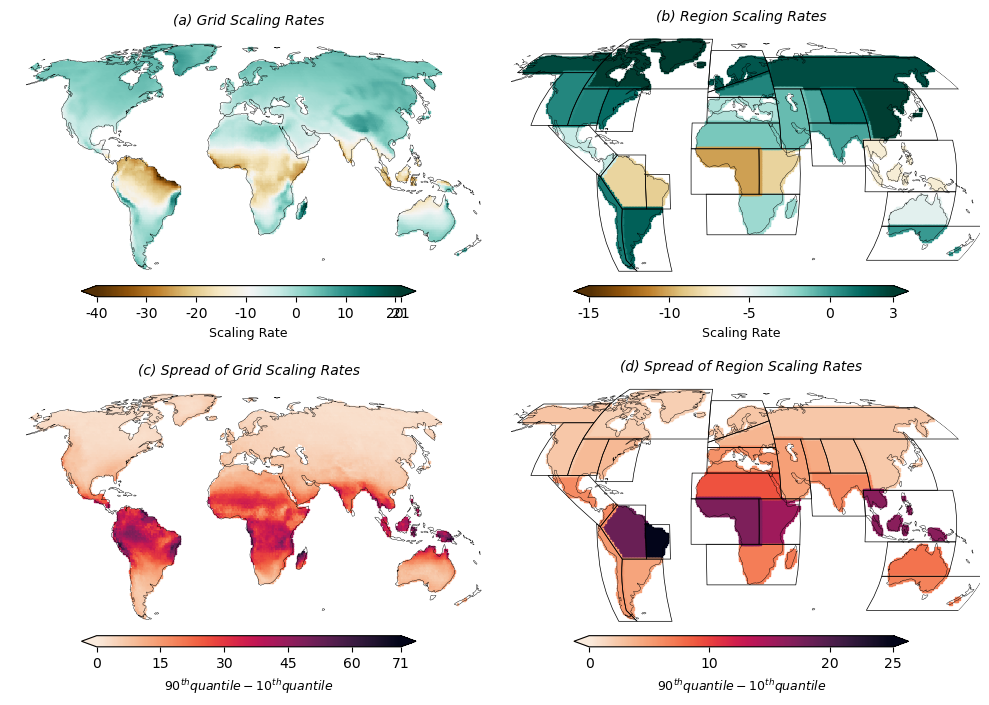

In [30]:
# Read the shapefile
shapefile_path = r"shapefle_path.shp"
gdf_shapefile = gpd.read_file(shapefile_path)
indices_to_drop = [3, 27, 28, 29, 30, 31, 32]
gdf_shapefile = gdf_shapefile.drop(indices_to_drop)

# Function to compute ticks based on specific intervals and ensure the max value is included exactly
def compute_ticks(data, interval):
    min_val = data.min()
    max_val = data.max()
    ticks = np.arange(min_val - min_val % interval, max_val + interval, interval)
    # Ensure the max value is included in the ticks if necessary
    if max_val not in ticks:
        ticks = np.append(ticks, max_val)
    # Remove any ticks that exceed the maximum value
    ticks = ticks[ticks <= max_val]
    return ticks

# Compute ticks for each dataset with specified intervals
ticks1 = compute_ticks(grid_avg['scaling'], 10)
ticks2 = compute_ticks(reg_avg['scaling'], 5)
ticks3 = compute_ticks(grid_spread['scaling'], 15)
ticks4 = compute_ticks(reg_spread['scaling'], 10)

# Define color palettes and normalization
cmap1 = sns.color_palette("BrBG", as_cmap=True)
norm1 = Normalize(vmin=min(ticks1), vmax=max(ticks1))

cmap2 = sns.color_palette("rocket_r", as_cmap=True)
norm2 = Normalize(vmin=min(ticks3), vmax=max(ticks3))

# Set up the figure and subplots with adjusted spacing
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), subplot_kw={'projection': ccrs.Robinson()})
plt.subplots_adjust(wspace=0.1, hspace=0.01)  # Adjust the horizontal and vertical spacing between subplots

# Plot the first chart (top-left)
axs[0, 0].coastlines(linewidth=0.3)
sc1_1 = axs[0, 0].scatter(grid_avg['lon'], grid_avg['lat'], c=grid_avg['scaling'], cmap=cmap1, norm=norm1, s=1, transform=ccrs.PlateCarree(), marker='s')
axs[0, 0].set_title('(a) Grid Scaling Rates', fontsize=10, style="italic", y=1.03)
axs[0, 0].set_frame_on(False)

# Plot the second chart (top-right)
axs[0, 1].coastlines(linewidth=0.3)
xy = axs[0, 1].projection.transform_points(ccrs.PlateCarree(), reg_avg['lon'].values, reg_avg['lat'].values)
sc1_2 = axs[0, 1].scatter(xy[:, 0], xy[:, 1], c=reg_avg['scaling'], cmap=cmap1, norm=Normalize(vmin=min(ticks2), vmax=max(ticks2)), s=5, marker='s')
axs[0, 1].add_geometries(gdf_shapefile.geometry, crs=ccrs.PlateCarree(), edgecolor="black", linewidth=0.5, facecolor='none')
axs[0, 1].set_title('(b) Region Scaling Rates', fontsize=10, style="italic", y=1.03)
axs[0, 1].set_frame_on(False)

# Plot the third chart (bottom-left)
axs[1, 0].coastlines(linewidth=0.3)
sc2_1 = axs[1, 0].scatter(grid_spread['lon'], grid_spread['lat'], c=grid_spread['scaling'], cmap=cmap2, norm=Normalize(vmin=min(ticks3), vmax=max(ticks3)), s=1, transform=ccrs.PlateCarree(), marker='s')
axs[1, 0].set_title('(c) Spread of Grid Scaling Rates', fontsize=10, style="italic", y=1.03)
axs[1, 0].set_frame_on(False)

# Plot the fourth chart (bottom-right)
axs[1, 1].coastlines(linewidth=0.3)
xy = axs[1, 1].projection.transform_points(ccrs.PlateCarree(), reg_spread['lon'].values, reg_spread['lat'].values)
sc2_2 = axs[1, 1].scatter(xy[:, 0], xy[:, 1], c=reg_spread['scaling'], cmap=cmap2, norm=Normalize(vmin=min(ticks4), vmax=max(ticks4)), s=5, marker='s')
axs[1, 1].add_geometries(gdf_shapefile.geometry, crs=ccrs.PlateCarree(), edgecolor='black', linewidth=0.5, facecolor='none')
axs[1, 1].set_title('(d) Spread of Region Scaling Rates', fontsize=10, style="italic", y=1.03)
axs[1, 1].set_frame_on(False)

# Add colorbars with appropriate ticks and labels
cbar1 = fig.colorbar(sc1_1, ax=axs[0, 0], orientation='horizontal', pad=0.02, fraction=0.03, aspect=30, extend="both", spacing="proportional")
cbar1.set_label('Scaling Rate', fontsize=9)
cbar1.set_ticks(ticks1)
cbar1.ax.set_xticklabels([f'{int(t)}' for t in ticks1])  

cbar2 = fig.colorbar(sc1_2, ax=axs[0, 1], orientation='horizontal', pad=0.02, fraction=0.03, aspect=30, extend="both", spacing="proportional")
cbar2.set_label('Scaling Rate', fontsize=9)
cbar2.set_ticks(ticks2)
cbar2.ax.set_xticklabels([f'{int(t)}' for t in ticks2])  

cbar3 = fig.colorbar(sc2_1, ax=axs[1, 0], orientation='horizontal', pad=0.02, fraction=0.03, aspect=30, extend="both", spacing="proportional")
cbar3.set_label('$90^{th} quantile - 10^{th} quantile$', fontsize=9)
cbar3.set_ticks(ticks3)
cbar3.ax.set_xticklabels([f'{int(t)}' for t in ticks3])  

cbar4 = fig.colorbar(sc2_2, ax=axs[1, 1], orientation='horizontal', pad=0.02, fraction=0.03, aspect=30, extend="both", spacing="proportional")
cbar4.set_label('$90^{th} quantile - 10^{th} quantile$', fontsize=9)
cbar4.set_ticks(ticks4)
cbar4.ax.set_xticklabels([f'{int(t)}' for t in ticks4])  

plt.savefig(r"save_path.png", dpi=600, bbox_inches='tight')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
